# Neural Network Classifier 

We are going to build a PyTorch neural network classifier using scRNAseq data. 

Helpful link:
Interfacing pytorch models with anndata: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/annloader.html

Possibly helpful about speeding up pytorch modeling: https://sebastianraschka.com/blog/2023/pytorch-faster.html

This program will:

- pull in scRNAseq data from cell_census
- wrangle the data for modelling
- appply the NN



## To Do:

- train, test, holdout and cross validation
- feature engineering to remove useless features
- ensure that leaf order matches in all the things
- when splitting the data for training/validation,  ensure that the number of genes is the same in both

## Done:
- use softmax for final layer
- use Cross entropy loss
- try ADAM optimizer, adjust learning rate
- plot loss curve
- use RELU for each layer
- plot accuracy curve
- add model.trend() and model.eval()
- add batch summarization 



In [1]:
#import cellxgene_census as cell_census
import anndata as ad

from pronto import Ontology

import pandas as pd
import numpy as np
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Read in the data

Times out after 1 minute and 7-8 seconds


In [ ]:
#cell_census.get_source_h5ad_uri("cb5efdb0-f91c-4cbd-9ad4-9d4fa41c572d")

In [3]:
adata = ad.read_h5ad('small_1044_900') # 42000 cells
#adata = ad.read_h5ad('leaf_list_in_cl') # 658000 cells

In [4]:
#census = cell_census.open_soma(census_version="latest")


In [5]:
cl = Ontology.from_obo_library('cl.owl')

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}description' at 0x151c999484a0> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}title' at 0x151c99948590> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://www.w3.org/2002/07/owl#}versionInfo' at 0x151c99948c20> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/parsers/rdfxml.py:113: SyntaxWarning: unknown element in `owl:ObjectProperty`: <Element '{

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://xmlns.com/foaf/0.1/}depicted_by
  self._extract_term(class_, curies)
/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://www.geneontology.org/formats/oboInOwl#}note
  self._extract_term(class_, curies)
/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.obolibrary.org/obo/}IAO_0000119
  self._extract_term(class_, curies)
/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.obolibrary.org/obo/}UBPROP_0000001
  self._extract_term(class_, curies)
/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/parsers/rdfx

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/UBPROP_0000004'
  cls(self).parse_from(_handle)  # type: ignore


In [6]:
def select_ontology_target_leafs(target_branch):
    '''
    This function identifies are leafs under the target_branch for an open ontology.
    
    Assumes there is an active ontology already open as cl.
    
    Parameters
    ----------
    target_branch : string
        string with ontological ID for branch you want to identify leafs for
        
    Returns
    -------
    leaf_lest : list
        list of ontology IDs for all leafs of target_branch
    
    '''
    root_node = cl[target_branch] 

    leaf_list = []

    for term in root_node.subclasses(distance=None,with_self=False).to_set():
        if term.is_leaf():
            leaf_list.append(term.id)
            
    return leaf_list

In [4]:
def get_data(organism, obs_val_filter, col_names):
    '''
    This function queries data from an active cell census object.
    
    Assumes there is an active census object already open. Assumes you only want to query on cell metadata. 
    Gene metadata querying not currently supported.
    
    Parameters
    ----------
    organism : string
        string containing type of organism you want to query for, i.e. 'Homo sapiens'
        
    obs_val_filter : string
        string containing obs parameters values to filter on
        
    col_names : dictionary
        dictionary of obs or val values to return
        
    Returns
    -------
        AnnData object
    
    '''
    adata = cell_census.get_anndata(
        census=census,
        organism = organism,
        obs_value_filter = obs_val_filter,
        column_names= col_names,
        )
    return adata
    

In [7]:
target_branch = 'CL:0000738' # leukocyte

leaf_list = select_ontology_target_leafs(target_branch)


In [8]:
obs_val_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in {}'''.format(leaf_list)
organism = "Homo sapiens"
col_names = {"obs": ["cell_type_ontology_term_id"]}


with cell_census.open_soma(census_version="latest") as census:
    adata = get_data(organism, obs_val_filter, col_names)

display(adata)

The "latest" release is currently 2023-06-12. Specify 'census_version="2023-06-12"' in future calls to open_soma() to ensure data consistency.


TileDBError: [TileDB::S3] Error: Error while listing with prefix 's3://cellxgene-data-public/cell-census/2023-06-12/soma/__schema/' and delimiter '/'
Exception:  
Error message:  curlCode: 28, Timeout was reached

In [7]:
obs_val_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in ['CL:0001044', 'CL:0000900', 'CL:0000934','CL:0001050','CL:0001049','CL:0000961','CL:0002349','CL:0000939']'''
#obs_val_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in ['CL:0001044', 'CL:0000900']'''

#obs_val_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in {}'''.format(leaf_list)


organism = "Homo sapiens"
col_names = {"obs": ["cell_type_ontology_term_id"]}
#col_names = {} # select all

adata = get_data(organism, obs_val_filter, col_names)

display(adata)

AnnData object with n_obs × n_vars = 93037 × 60664
    obs: 'cell_type_ontology_term_id', 'assay'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [6]:
display(adata)

AnnData object with n_obs × n_vars = 42017 × 60664
    obs: 'cell_type_ontology_term_id', 'assay'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

## Encode and Split the Data into Train/Validate to prepare for modeling

Encode the label values, then split the data into testing and training sets, then put into PyTorch Tensors.


In [7]:
def preprocess_data(adata, target_column):
    '''
    This function perfroms preprocessing on ann AnnData object to prepare it for modelling. It will encode the 
    target column and returns x_data and y_data for modelling
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # encode the target column
    lb = LabelEncoder()
    labels['encoded_labels'] = lb.fit_transform(labels[target_column])

    
    x_data = adata.X.copy()
    y_data = labels['encoded_labels']
    
    return(x_data,y_data, labels)

In [25]:
def split_format_data(x_data, y_data, train_size):
    '''
    This function splits x_data and y_data into training and validation sets, then formats the data into
    tensors for modeling with PyTorch
    
    
    Parameters
    ----------
    x_data : scipy matrix
        scipy sparse CSR matrix  
        
    y_data : Series
        Pandas series of encoded target values
        
    train_size: float
        float between 0.0 and 1.0 to select the training fraction of the data set
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    '''
    
    # split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(x_data,y_data,
                                                   train_size = train_size)
    
    
    # convert the data to tensors
    # we'll change the data from CSR (compressed sparse row) format
    # to COO (coordinate) format for better use with pytorch
    # see https://pytorch.org/docs/stable/sparse.html for additional details
    # conversion from COO to tensor based on https://stackoverflow.com/questions/50665141/converting-a-scipy-coo-matrix-to-pytorch-sparse-tensor


    if device.type == "cuda":
        X_train_coo = X_train.tocoo()
        X_train = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_train_coo.row,X_train_coo.col))),
                                      torch.FloatTensor(X_train_coo.data))

        # y_train is a Series, so it is easier to convert to a tensor
        y_train = torch.tensor(y_train, dtype=torch.long)


        # and the same for the validation set
        X_val_coo = X_val.tocoo()
        X_val = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_val_coo.row,X_val_coo.col))),
                                          torch.FloatTensor(X_val_coo.data))

        # y_val is a Series, so it is easier to convert to a tensor
        y_val = torch.tensor(y_val, dtype=torch.long)
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_val = X_val.to(device)
        y_val = y_val.to(device)
            
        
        
    else:    
        X_train_coo = X_train.tocoo()
        X_train = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_train_coo.row,X_train_coo.col))),
                                      torch.FloatTensor(X_train_coo.data))

        # y_train is a Series, so it is easier to convert to a tensor
        y_train = torch.tensor(y_train, dtype=torch.long)


        # and the same for the validation set
        X_val_coo = X_val.tocoo()
        X_val = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((X_val_coo.row,X_val_coo.col))),
                                          torch.FloatTensor(X_val_coo.data))

        # y_val is a Series, so it is easier to convert to a tensor
        y_val = torch.tensor(y_val, dtype=torch.long)
                
            
    # check if number of genes in X_train = X_val
    # rarely, splitting the dataset can cause a difference
    # if it does, resplit the data by looping back into this function

    
    #print(X_train.shape)
    #print(X_val.shape)
    if X_train.shape[1] != X_val.shape[1]:
        print('Number of genes in X_train does not equal number of genes in X_val. Splitting again.')
        X_train, X_val, y_train, y_val = split_format_data(x_data, y_data, train_size = train_size)
    else:
        print('Success. Number of genes in X_train equals number of genes in X_val')

    return(X_train, X_val, y_train, y_val)

In [9]:
def preprocess_ontology(adata,target_column,upper_limit = None, include_leafs = False, cl_only = False, only_leafs_for_targets=False):
    '''
    This function processes the ontology to build a pandas dataframe that can be used to 
    calculate predicted probabilities. This will enable simple matrix multiplication to calculate
    probabilities and loss.
    
    Does not have a forced upper limit in the ontology.
    
    Assumes there is an active census object already open as cl. 
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
    upper_limit : string
        if you want to specify an upper limit in the ontology, set this to 
        the upper limit (inclusive)
        Default: None (no limit to ontology)
        
    include_leafs : boolean
        option to include leafs in the list of parent cell IDs
        Default is False because we are calculating the leaf loss differently
        Default: False
        
    cl_only : boolean
        option to only include the Cell Ontology (CL) in the dataframe
        True means only those cell IDs that start with CL are included
        Default: False
        
    only_leafs_for_targets : boolean
        option to specify that targets are already known to include leafs
        Default: False - program will check all targets and find any additional leafs
                True means that list of unique values in the target column will be used

        
    Returns
    -------
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # select the unique target values
    target_values = labels[target_column].unique()
    
    # check that these are leaf nodes
    # if not, find the leaf under that value
    
    if only_leafs_for_targets:
        leaf_nodes = target_values
    else:
        leaf_nodes = []
        for target in target_values:
            if cl[target].is_leaf():
                leaf_nodes.append(target)
            else:
                for term in cl[target].subclasses(distance=None,with_self=False).to_set():
                    if term.is_leaf():
                        leaf_nodes.append(term.id)
    
    # ensure that we do not have duplicate values
    leaf_nodes = list(set(leaf_nodes))
    
    
    # now get all parent nodes
    # if we want to include leafs, set with_self = True
    # else, set with_self = False
    parent_nodes = []
    for target in target_values:
        for term in cl[target].superclasses(distance=None,with_self=include_leafs).to_set():
            parent_nodes.append(term.id)
            
    # ensure that we do not have duplicate values
    parent_nodes = list(set(parent_nodes))

    # select only the Cell Ontology IDs if cl_only = True
    if cl_only:
        parent_nodes = [x for x in parent_nodes if x.startswith('CL')]
    
    # if there is an upper limit, 
    if upper_limit is not None:
        # get upper limit nodes
        upper_limit_nodes = []
        for term in cl[upper_limit].superclasses(distance=None,with_self=False).to_set():
            upper_limit_nodes.append(term.id)
            
        # remove these nodes from the parent_nodes list
        parent_nodes = [x for x in parent_nodes if x not in upper_limit_nodes]
        
    
    # create the dataframe
    ontology_df = pd.DataFrame(data=0, index = parent_nodes,
                                              columns = leaf_nodes)


    # populate the dataframe with 1 if column leaf is a leaf 
    # for that particular cell ID
    # with_self = True because we need to include the leafs here
    for cell_id in ontology_df.index:
        for term in cl[cell_id].subclasses(distance=None,with_self=True).to_set():
            if term.id in ontology_df.columns:
                ontology_df.loc[cell_id,[term.id]] = [1]
                    
    
    return(ontology_df)

In [26]:
target_column = 'cell_type_ontology_term_id'

upper_limit = 'CL:0000738' # leukocyte = 738

print('start preprocess ontology')
ontology_df = preprocess_ontology(adata,target_column,upper_limit = upper_limit, include_leafs = False, cl_only=True,only_leafs_for_targets=True)

print('start preprocess data')
x_data, y_data, labels = preprocess_data(adata,target_column)

train_size = 0.70

print('start split and format data')
X_train, X_val, y_train, y_val = split_format_data(x_data, y_data, train_size)


start preprocess ontology
start preprocess data
start split and format data
Success. Number of genes in X_train equals number of genes in X_val


In [28]:
#print(X_train.is_cpu)
#print(X_val.is_cuda())
#print(y_train.get_device())
#print(y_val.is_cuda())
type(X_train)

print('X_train size in MB: ', X_train.element_size() * X_train.nelement() * 10e-6)

print('X_val size in MB: ', X_val.element_size() * X_val.nelement() * 10e-6)

print('y_train size in MB: ', y_train.element_size() * y_train.nelement() * 10e-6)

print('y_val size in MB: ', y_val.element_size() * y_val.nelement() * 10e-6)


X_train size in MB:  71051.0938
X_val size in MB:  30453.574800000002
y_train size in MB:  2.3528800000000003
y_val size in MB:  1.00848


In [29]:
# check that tensors are on gpu. if on gpu, get_device returns 0, if on cpu, returns -1

print(X_train.get_device())
print(X_val.get_device())
print(y_train.get_device())
print(y_val.get_device())


0
0
0
0


## Build Neural Network Classifier


In [30]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = X_train.size(dim=1) #adata.X.shape[1] 

# number of hidden layers
hidden_layers = 10

# number of classes (unique of y)
output_dim = torch.unique(y_train).size(dim=0) #labels['encoded_labels'].nunique()

print(input_dim,hidden_layers,output_dim)

60395 10 2


In [31]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layers)
        self.linear2 = nn.Linear(hidden_layers,output_dim)
        self.bn = nn.BatchNorm1d(10)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.softmax(x,dim=1)
        return x

## Functions for dealing with tree ontology and loss


In [38]:
def output_probability_tensor(outputs,ontology_df):
    '''
    Function to convolve the predicted classification outputs with the ontology heirarchy to
    get predicted normalized probabilities for all parents. 
    Precursur to loss calculation
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    sum_probability_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
        
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.FloatTensor(ontology_df.values)
    ontology_tensor = ontology_tensor.to(device)
        
    # convole the ontology tensor with the predicted outputs
    # ontology tensor is shape ij, where i = parent IDs, j = probability for leaf IDs
    # output tensor is shape kj, where k = number of cells classified, j = probability for leaf IDs
    # probability tensor is shape ijk

    probability_tensor = torch.einsum('ij,kj->ijk',ontology_tensor,outputs)
    #print('prob_tensor', probability_tensor.shape)
    
    # sum across leafs to get the predicted probability, by cell, for each
    # parent 
    # sum_probability_tensor is shape ik, where i = parent IDs, k = number of cells
    sum_probability_tensor = torch.sum(probability_tensor,dim=1,dtype=float)
    #print('sum_prob', sum_probability_tensor.shape)
        
    # ensure that the max value is 1 because of floating point issues
    # if we don't do this, we can run into errors with the binary cross entropy
    sum_probability_tensor = torch.where(sum_probability_tensor > 1, 1.0, sum_probability_tensor )
    
    
    return sum_probability_tensor


In [33]:
def target_probability_tensor(target_values,ontology_df):
    '''
    Function to convolve the known target values with the ontology heirarchy
    Precursur to loss calculation
    
    Parameters
    ----------
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
    # loop through target values, pick out corresponding column of ontology_df
    # append that to a tensor
    
    for count, target_value in enumerate(target_values):
        sub_target_tensor = torch.tensor(ontology_df.iloc[:,target_value.item()].values,dtype=float).reshape(-1,1)

        if count == 0 :
            target_tensor = sub_target_tensor
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,sub_target_tensor),1).requires_grad_()
    target_tensor = target_tensor.to(device)
    return target_tensor

# Marginalization Classification 

- Based on Dahll, et al., Hierarchical Image Classification using Entailment Cone Embeddings, CVPR 202
- https://arxiv.org/pdf/2004.03459.pdf
- Thesis slides: https://ankitdhall.github.io/publication/learning-representations-for-images-with-hierarchical-labels/master_thesis.pdf
- First Author website: https://ankitdhall.github.io/project/learning-representations-for-images-with-hierarchical-labels/

Outline:
1) Forward Propogation
2) Get outputs (outputs_train)
3) get probability dictionary for outputs (add_probability_to_parent_nodes).
4) get tree structure and run softmax on each layer
5) use y_train to make probability dictionary y tree
6) calculate the loss across all levels



In [22]:
def marginalization_classification(X_train,X_val,y_train,y_val,num_epochs,ontology_df):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. Accounts for entire tree structure of the ontology by classifying to the leaf nodes, 
    propogating the probabilities across the ontology, and calculating the loss for both the leafs 
    and parent nodes. 
    
    Parameters
    ----------
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    
    num_epochs : int
        integer specify the number of epochs
        
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    Returns
    -------    
    marginalization_dict : dictionary
        dictionary containing results from each epoch of the neural network
    
    Keys and Values include:
    
        accuracy_train_hist : list
            list containing accuracy for the training set per epoch
        
        loss_train_hist: list
            list containing total loss values for the training set per epoch
            
        loss_train_leaf_hist : list
            list containing loss values for leaf nodes for the training set per epoch
            
        loss_train_parents_hist : list
            list containing loss values for parent nodes for the training set per epoch
        
        accuracy_val_hist : list 
            list containing accuracy for the validation set per epoch
        
        loss_val_hist : list
            list containing total loss values for the validation set per epoch
            
        loss_val_leaf_hist : list
            list containing loss values for leaf nodes for the validation set per epoch
            
        loss_val_parents_hist : list
            list containing loss values for parent nodes for the validation set per epoch
            
        best_output : tensor
            PyTorch tensor containing the predicted probabilites for the most accurate
            epoch

    '''
    # initialize variables for saving values
    accuracy_train_hist = []
    loss_train_leaf_hist = []
    loss_train_parents_hist = []
    loss_train_hist = []
    accuracy_val_hist = []
    loss_val_hist = []
    loss_val_leaf_hist = []
    loss_val_parents_hist = []

    best_accuracy = - np.inf
    best_weights = None

    # initialize network
    clf = Network()
    clf.to(device)
    # define loss and optimizer
    # we use two different loss methods for the leafs and parents
    # use Cross Entory Loss for leafs, because those probabilities are normalized
    #     and it is thus a multi-class problem
    # Use BCELoss for the parents because this is a multi-label problem
    #     and the probabilities are normalized, so we don't need BCELossWithLogits
    # initialize both here
    criterion_leafs = nn.CrossEntropyLoss()
    criterion_parents = nn.BCELoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        running_train_loss = 0.0
        #running_accuracy = 0.0
        #running_vallidation_loss = 0.0
        #total = 0

        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()

        # forward propagation
        outputs_train = clf(X_train.float())
                        
        # calculate loss for just the leafs
        loss_train_leafs = criterion_leafs(outputs_train, y_train)
        
        # calculate the loss for the parents
        output_train_parent_prob = output_probability_tensor(outputs_train,ontology_df)
        target_train_parent_prob = target_probability_tensor(y_train,ontology_df)
        print(output_train_parent_prob.get_device())
        print(target_train_parent_prob.get_device())

        loss_train_parents = criterion_parents(output_train_parent_prob,target_train_parent_prob)

        # sum the loss for both leafs and parents
        loss_train = loss_train_leafs + loss_train_parents
        
        # backward propagation
        loss_train.backward()

        # optimize
        optimizer.step()
        running_train_loss += loss_train.item()

        # save accuracy
        _, train_pred = outputs_train.max(dim=1)
        correct_train = (train_pred == y_train).sum().item()
        accuracy_train_hist.append(correct_train / len(y_train) * 100.)

        # save loss
        loss_train_hist.append(loss_train.item())
        loss_train_leaf_hist.append(loss_train_leafs.item())
        loss_train_parents_hist.append(loss_train_parents.item())

        
        with torch.no_grad():
            clf.eval()
            # calculate output by running through the network
            outputs_val = clf(X_val.float())

            # get the predictions
            __, predicted_val = outputs_val.max(dim=1)            
            
            # calculate loss for just the leafs
            loss_val_leafs = criterion_leafs(outputs_val, y_val)
        
            # calculate the loss for the parents
            output_val_parent_prob = output_probability_tensor(outputs_val,ontology_df)
            target_val_parent_prob = target_probability_tensor(y_val,ontology_df)
            
            loss_val_parents = criterion_parents(output_val_parent_prob,target_val_parent_prob)

            # sum the loss for both leafs and parents
            loss_val = loss_val_leafs + loss_val_parents
            
            # save accuracy
            correct_val = (predicted_val == y_val).sum().item()
            accuracy_val_hist.append(correct_val / len(y_val) * 100.)

            # save loss
            loss_val_hist.append(loss_val.item())
            loss_val_leaf_hist.append(loss_val_leafs.item())
            loss_val_parents_hist.append(loss_val_parents.item())

            
            # check if best model
            if accuracy_val_hist[-1] > best_accuracy:
                best_acc = accuracy_val_hist[-1]
                best_weights = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_hist[-1]:.8f} Validation Accuracy: {accuracy_val_hist[-1]:.8f}')

    print(f'Best Validation Accuracy: {best_acc:.3f}')
    #print('Best Weights: ')
    #print(best_weights)
    
    # build dictionary to return values
    marginalization_dict = {}
    marginalization_dict['accuracy_train_hist'] = accuracy_train_hist
    marginalization_dict['loss_train_hist'] = loss_train_hist
    
    marginalization_dict['loss_train_leaf_hist'] = loss_train_leaf_hist
    marginalization_dict['loss_train_parents_hist'] = loss_train_parents_hist

    marginalization_dict['accuracy_val_hist'] = accuracy_val_hist
    marginalization_dict['loss_val_hist'] = loss_val_hist

    marginalization_dict['loss_val_leaf_hist'] = loss_val_leaf_hist
    marginalization_dict['loss_val_parents_hist'] = loss_val_parents_hist
    
    marginalization_dict['best_output'] = best_output

    #return(accuracy_train_hist, loss_train_hist, loss_train_leaf_hist, loss_train_parents_hist, accuracy_val_hist, loss_val_hist, loss_val_leaf_hist, loss_val_parents_hist, best_output)
    return marginalization_dict

In [17]:
X_train.is_cuda

True

In [23]:
start = time.time()
num_epochs = 1

number_of_leafs = labels['encoded_labels'].unique().size
number_of_parents = ontology_df.shape[0]

print('There are', number_of_leafs, 'leafs and', number_of_parents, 'parents.')

#label_dict = {}

#for x in range(number_of_leafs):
#    label_dict[x] = labels[labels['encoded_labels'] == x][target_column].unique().tolist()[0]

#accuracy_train_hist, loss_train_hist, loss_train_leaf_hist, loss_train_parents_hist, accuracy_val_hist, loss_val_hist, loss_val_leaf_hist, loss_val_parents_hist, best_output = marginalization_classification(X_train,X_val,y_train,y_val,num_epochs,label_dict, ontology_df)

marginalization_dict = marginalization_classification(X_train,X_val,y_train,y_val,num_epochs, ontology_df)

end = time.time()
print('run time: ', (end-start))

There are 2 leafs and 12 parents.
0
torch.Size([29411, 2])
0
0


RuntimeError: addmm: Argument #3 (dense): Expected dim 0 size 60392, got 60395

Start was 11:00


/tmp/ipykernel_269278/312188734.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


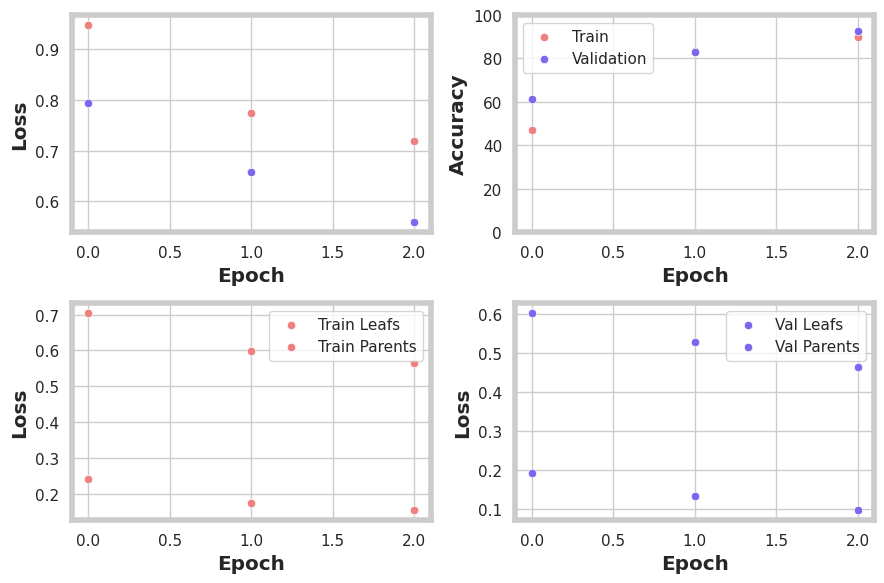

In [39]:
fig, ax = plt.subplots(2,2,figsize=(9,6))
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_train_hist'], ax = ax[0,0],color='lightcoral')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['accuracy_train_hist'], ax = ax[0,1],color='lightcoral',label='Train')

sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_val_hist'], ax = ax[0,0],color='mediumslateblue')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['accuracy_val_hist'], ax = ax[0,1],color='mediumslateblue',label='Validation')

sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_train_leaf_hist'], ax = ax[1,0],color='lightcoral',label='Train Leafs')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_train_parents_hist'], ax = ax[1,0],color='lightcoral',label='Train Parents')

sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_val_leaf_hist'], ax = ax[1,1],color='mediumslateblue',label='Val Leafs')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_val_parents_hist'], ax = ax[1,1],color='mediumslateblue',label='Val Parents')


ax[0,0].set_xlabel('Epoch')
ax[0,1].set_xlabel('Epoch')
ax[1,0].set_xlabel('Epoch')
ax[1,1].set_xlabel('Epoch')

ax[0,0].set_ylabel('Loss')
ax[0,1].set_ylabel('Accuracy')
ax[1,0].set_ylabel('Loss')
ax[1,1].set_ylabel('Loss')

ax[0,1].set_ylim((0,100))
fig.show()

## Marginalization with DataLoader

In [68]:
def marginalization_classification_with_batches(train_loader,X_val,y_val,num_epochs,ontology_df):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. Accounts for entire tree structure of the ontology by classifying to the leaf nodes, 
    propogating the probabilities across the ontology, and calculating the loss for both the leafs 
    and parent nodes. 
    
    Parameters
    ----------
    train_loader : DataLoader Tensor
        pytorch tensor of training and target values from Pytorch DataLoader
    
    X_val : Tensor
        pytorch tensor of validation values
                
    y_val : Tensor
        pytorch tensor of validation target values
    
    num_epochs : int
        integer specify the number of epochs
        
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    Returns
    -------    
    marginalization_dict : dictionary
        dictionary containing results from each epoch of the neural network
    
    Keys and Values include:
    
        accuracy_train_hist : list
            list containing accuracy for the training set per epoch
        
        loss_train_hist: list
            list containing total loss values for the training set per epoch
            
        loss_train_leaf_hist : list
            list containing loss values for leaf nodes for the training set per epoch
            
        loss_train_parents_hist : list
            list containing loss values for parent nodes for the training set per epoch
        
        accuracy_val_hist : list 
            list containing accuracy for the validation set per epoch
        
        loss_val_hist : list
            list containing total loss values for the validation set per epoch
            
        loss_val_leaf_hist : list
            list containing loss values for leaf nodes for the validation set per epoch
            
        loss_val_parents_hist : list
            list containing loss values for parent nodes for the validation set per epoch
            
        best_output : tensor
            PyTorch tensor containing the predicted probabilites for the most accurate
            epoch

    '''
    # initialize variables for saving values
    accuracy_train_hist = []
    loss_train_leaf_hist = []
    loss_train_parents_hist = []
    loss_train_hist = []
    accuracy_val_hist = []
    loss_val_hist = []
    loss_val_leaf_hist = []
    loss_val_parents_hist = []

    best_accuracy = - np.inf
    best_weights = None

    # initialize network
    clf = Network()
    clf.to(device)

    # define loss and optimizer
    # we use two different loss methods for the leafs and parents
    # use Cross Entory Loss for leafs, because those probabilities are normalized
    #     and it is thus a multi-class problem
    # Use BCELoss for the parents because this is a multi-label problem
    #     and the probabilities are normalized, so we don't need BCELossWithLogits
    # initialize both here
    criterion_leafs = nn.CrossEntropyLoss()
    criterion_parents = nn.BCELoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        print('on epoch', epoch)
        
        # TRAINING
        clf.train()
        running_train_loss = 0.0
        #running_accuracy = 0.0
        #running_vallidation_loss = 0.0
        #total = 0
        
        correct_train = 0
        y_length = 0

        for i, (X_train, y_train) in enumerate(train_loader):
            #print('on batch', i)
            # every data instance is input + label pair
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            
            # set optimizer to zero grad to remove previous epoch gradients
            optimizer.zero_grad()
            
            # make predictions for this batch
            outputs_train = clf(X_train) # might need to change to X_train.float()
            
            # calculate loss for just the leafs
            loss_train_leafs = criterion_leafs(outputs_train, y_train)

            # calculate the loss for the parents
            output_train_parent_prob = output_probability_tensor(outputs_train,ontology_df)
            target_train_parent_prob = target_probability_tensor(y_train,ontology_df)

            loss_train_parents = criterion_parents(output_train_parent_prob,target_train_parent_prob)

            # sum the loss for both leafs and parents
            loss_train = loss_train_leafs + loss_train_parents

            # backward propagation
            loss_train.backward()

            # optimize
            optimizer.step()
 
            running_train_loss += loss_train.item()
    
            # save accuracy
            _, train_pred_per_epoch = outputs_train.max(dim=1)
            correct_train += (train_pred_per_epoch == y_train).sum().item()
            y_length += len(y_train)

   

        # save accuracy
        #_, train_pred = outputs_train.max(dim=1)
        #correct_train = (train_pred == y_train).sum().item()
        print(correct_train)
        print(y_length)
        accuracy_train_hist.append(correct_train / y_length * 100.)

        # save loss
        loss_train_hist.append(loss_train.item())
        loss_train_leaf_hist.append(loss_train_leafs.item())
        loss_train_parents_hist.append(loss_train_parents.item())

        
        with torch.no_grad():
            clf.eval()
            # calculate output by running through the network
            outputs_val = clf(X_val.float())

            # get the predictions
            __, predicted_val = outputs_val.max(dim=1)            
            
            # calculate loss for just the leafs
            loss_val_leafs = criterion_leafs(outputs_val, y_val)
        
            # calculate the loss for the parents
            output_val_parent_prob = output_probability_tensor(outputs_val,ontology_df)
            target_val_parent_prob = target_probability_tensor(y_val,ontology_df)
            
            loss_val_parents = criterion_parents(output_val_parent_prob,target_val_parent_prob)

            # sum the loss for both leafs and parents
            loss_val = loss_val_leafs + loss_val_parents
            
            # save accuracy
            correct_val = (predicted_val == y_val).sum().item()
            accuracy_val_hist.append(correct_val / len(y_val) * 100.)

            # save loss
            loss_val_hist.append(loss_val.item())
            loss_val_leaf_hist.append(loss_val_leafs.item())
            loss_val_parents_hist.append(loss_val_parents.item())

            
            # check if best model
            if accuracy_val_hist[-1] > best_accuracy:
                best_acc = accuracy_val_hist[-1]
                best_weights = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_hist[-1]:.8f} Validation Accuracy: {accuracy_val_hist[-1]:.8f}')

    print(f'Best Validation Accuracy: {best_acc:.3f}')
    #print('Best Weights: ')
    #print(best_weights)
    
    # build dictionary to return values
    marginalization_dict = {}
    marginalization_dict['accuracy_train_hist'] = accuracy_train_hist
    marginalization_dict['loss_train_hist'] = loss_train_hist
    
    marginalization_dict['loss_train_leaf_hist'] = loss_train_leaf_hist
    marginalization_dict['loss_train_parents_hist'] = loss_train_parents_hist

    marginalization_dict['accuracy_val_hist'] = accuracy_val_hist
    marginalization_dict['loss_val_hist'] = loss_val_hist

    marginalization_dict['loss_val_leaf_hist'] = loss_val_leaf_hist
    marginalization_dict['loss_val_parents_hist'] = loss_val_parents_hist
    
    marginalization_dict['best_output'] = best_output

    #return(accuracy_train_hist, loss_train_hist, loss_train_leaf_hist, loss_train_parents_hist, accuracy_val_hist, loss_val_hist, loss_val_leaf_hist, loss_val_parents_hist, best_output)
    return marginalization_dict


In [35]:
print(device.type)

cuda


In [57]:
len(train_set)

29411

In [45]:
y_train.shape

torch.Size([29411])

In [71]:
# create the DataLoader datsets for batch purposes
train_set = torch.utils.data.TensorDataset(X_train,y_train)

# set these if on GPU 
##kwargs = {'num_workers': 1, 'pin_memory': True} if device.type=='cuda' else {}


dataset_breakdown = 5
batch_size = 5000 # int(y_train.shape[0] / 5)
# set drop_last = True to drop the last batch iff it is a different size
train_loader = torch.utils.data.DataLoader(dataset = train_set,batch_size=batch_size,shuffle=True,drop_last=True)#,**kwargs)


num_epochs = 5

number_of_leafs = labels['encoded_labels'].unique().size
number_of_parents = ontology_df.shape[0]

print('There are', number_of_leafs, 'leafs and', number_of_parents, 'parents.')

marginalization_dict = marginalization_classification_with_batches(train_loader,X_val,y_val,num_epochs, ontology_df)


There are 2 leafs and 12 parents.
on epoch 0
18732
25000
[1] Training Accuracy: 74.92800000 Validation Accuracy: 87.08551483
on epoch 1
22085
25000
on epoch 2
22380
25000
on epoch 3
22626
25000
on epoch 4
22801
25000
Best Validation Accuracy: 90.965


/tmp/ipykernel_289231/312188734.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


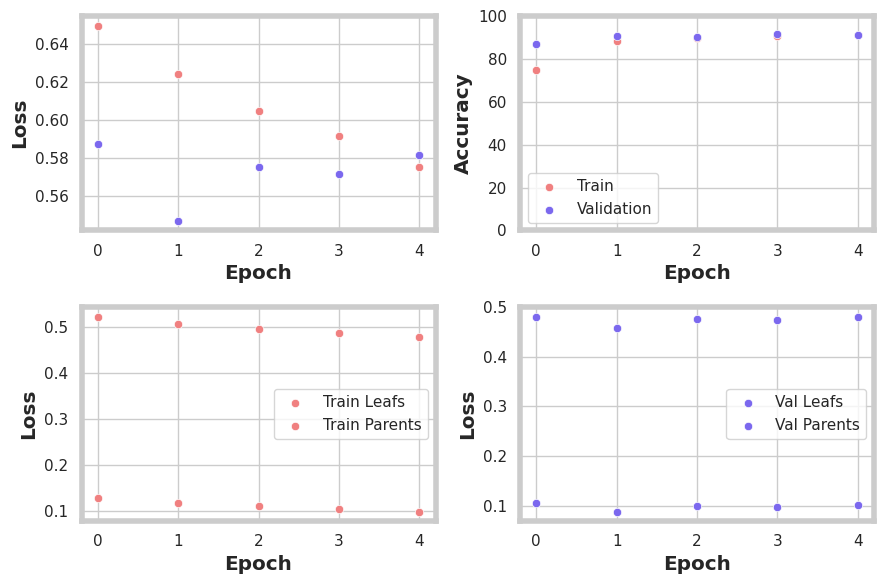

In [72]:
fig, ax = plt.subplots(2,2,figsize=(9,6))
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_train_hist'], ax = ax[0,0],color='lightcoral')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['accuracy_train_hist'], ax = ax[0,1],color='lightcoral',label='Train')

sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_val_hist'], ax = ax[0,0],color='mediumslateblue')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['accuracy_val_hist'], ax = ax[0,1],color='mediumslateblue',label='Validation')

sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_train_leaf_hist'], ax = ax[1,0],color='lightcoral',label='Train Leafs')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_train_parents_hist'], ax = ax[1,0],color='lightcoral',label='Train Parents')

sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_val_leaf_hist'], ax = ax[1,1],color='mediumslateblue',label='Val Leafs')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_val_parents_hist'], ax = ax[1,1],color='mediumslateblue',label='Val Parents')


ax[0,0].set_xlabel('Epoch')
ax[0,1].set_xlabel('Epoch')
ax[1,0].set_xlabel('Epoch')
ax[1,1].set_xlabel('Epoch')

ax[0,0].set_ylabel('Loss')
ax[0,1].set_ylabel('Accuracy')
ax[1,0].set_ylabel('Loss')
ax[1,1].set_ylabel('Loss')

ax[0,1].set_ylim((0,100))
fig.show()